# **Set according to environment (e.g. local, Google Colab...)**

In [5]:
project_folder = ''

# **Custom library**

In [6]:
from custom_libraries.miscellaneous import progress_bar
from custom_libraries.image_dataset import *
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
bs = 256
weighting = 'paired'
trials = 10
classes = 10

ds_set = ['mnist', 'fmnist', 'kmnist', 'svhn', 'usps', 'cifar10']

paired_test = np.zeros((len(ds_set), trials, classes, classes))
heatmap_matrix = np.zeros((len(ds_set), classes, classes))

for k, ds in enumerate(ds_set):

    print(f"- Dataset: {ds}")
    test_ds = ImageDataset(ds, 'test', data_dir=None, USPS_dir=project_folder+'USPS/')
    train_ds = ImageDataset(ds, 'train', data_dir=None, USPS_dir=project_folder+'USPS/')

    for x in [train_ds, test_ds]:
        x.shuffle()
        x.normalize()
        if x.images.shape[1:3] == (28, 28):
            x.pad()
        x.vectorize(True)

    for t1 in range(10):
        for t2 in range(t1 + 1, 10):

            finished = False

            while not finished:

              try:

                progress_bar(0, max = 10, pre = f"-- Pair {t1} - {t2}:\t")
                train_ds.shuffle()
                test_ds.shuffle()
                X_test, y_test = test_ds.filter(t1, t2)
                X_train, y_train = train_ds.filter(t1, t2)
                # Per coerenza con Jones&Kording
                train_len = len(X_train)-len(X_test)
                X_train, y_train = [X_train[i] for i in range(train_len)], [y_train[i] for i in range(train_len)]

                X_train = np.array_split(X_train, trials)
                y_train = np.array_split(y_train, trials)

                average_acc = 0

                for m in range(trials):

                    lda = LinearDiscriminantAnalysis()
                    lda.fit(X_train[m], y_train[m])
                    score_test = lda.score(X_test, y_test)

                    paired_test[k, m, t1, t2] = score_test
                    average_acc = average_acc + score_test

                    progress_bar(m+1, max = 10, pre = f"-- Pair {t1} - {t2}:\t")

                heatmap_matrix[k][t1][t2], heatmap_matrix[k][t2][t1] = average_acc / trials, average_acc / trials

                progress_bar(10, max = 10, pre = f"-- Pair {t1} - {t2}:\t", post = f"\tAccuracy = {heatmap_matrix[k][t1][t2]}")
                print()

                finished = True

              except:

                print("\nAn error occurred. Repeating the pair.")

# Salvo il risultato in un binario numpy
np.save(project_folder + 'results/confused_pairs_all.npy', paired_test)
np.save(project_folder + 'results/confused_pairs_matrix.npy', heatmap_matrix)


- Dataset: mnist
-- Pair 0 - 1:	[====================] 100%	Accuracy = 0.9799054373522459
-- Pair 0 - 2:	[====================] 100%	Accuracy = 0.9492047713717693
-- Pair 0 - 3:	[====================] 100%	Accuracy = 0.9687939698492463
-- Pair 0 - 4:	[====================] 100%	Accuracy = 0.9682466870540264
-- Pair 0 - 5:	[                    ] 0%

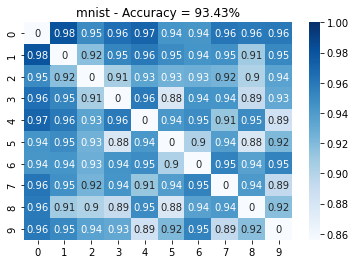

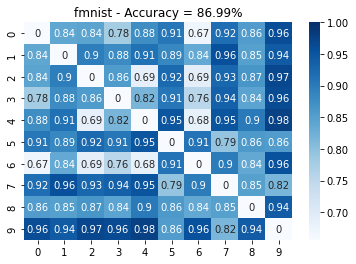

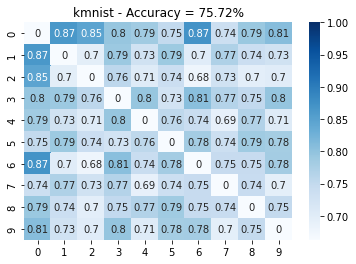

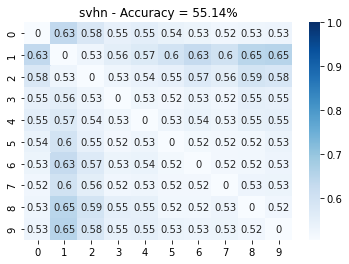

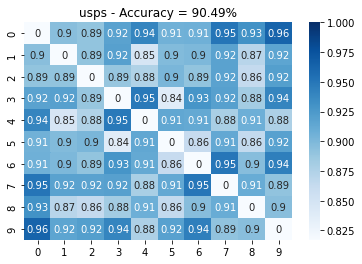

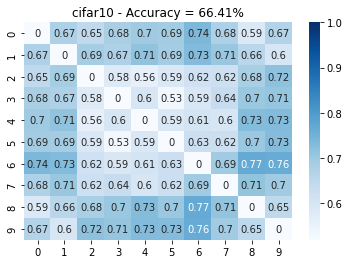

In [12]:
# Plotto heatmap matrix

heatmap_matrix = np.load(project_folder + 'results/confused_pairs_matrix.npy')
ds_set = ['mnist', 'fmnist', 'kmnist', 'svhn', 'usps', 'cifar10']

for k in range(len(ds_set)):
    heat = heatmap_matrix[k]
    min_acc = .975 * min(heat[np.nonzero(heat)])
    plt.figure()
    ax = sns.heatmap(heat, annot=True, cmap='Blues', vmin = min_acc, vmax = 1)
    ax.set_title(ds_set[k]+f" - Accuracy = {round(np.mean(heat[np.nonzero(heat)])*100, 2)}%")